In [1]:
##################################
# Program to analyze mouse dorsal horn - comparison to macaque
##################################
#Annotates macaque single cells based on mouse clusters
#Version 1.3 - Hiearchically compare the different subtypes of neurons
#Version 1.4 - Filter based on on common genes
#            - Remove CSF-cN   
#            - Add family relationships
#Version 1.5 - Add cynthia's list
#            - Make numMarkers consistent
#            - Visualize individual mouse clusters in macaque
#            - Mid september presentaiton freeze
#            - Add code for looking at evolution
#Version 1.6 - Polish for figures (add mouse cluster order)
#Version 2.1 - Use different version of macaque HDA5 file with paper names
#Version 2.2 - Add full comparison to the mouse
#            - Switch to pfen2/large script
#Version 2.2.2 - Split Adamts5-Rorb cluster
#Version 3.1.1 - Fully comprehensive analysis, Michael new reprocessing
#Version 3.1.3 - Cleaner version

In [2]:
import numpy as np
import scanpy as sc
import pandas as pd
from anndata import AnnData
import anndata
import fileinput


In [3]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15,10

In [4]:
from sklearn.preprocessing import scale

In [5]:
from scipy import stats
from scipy import spatial
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage

import statistics 

np.random.seed(1234)

In [6]:
import loompy

In [170]:
import seaborn as sns

In [7]:
#Read in the h5ad file for the mouse neuron dh RNA-Seq, fully processed file
#mmDh_proc_neuron_ann_fn = "/pylon5/mc5plqp/apfennin/dorsalHorn/mmData/mmDh_proc_neuron_ann_1.h5ad"
mmDh_proc_neuron_ann_fn = "/home/apfennin/projects/dorsalHorn/mmData/mmDh_proc_neuron_ann_1.h5ad";
mmDh_proc_neuron_ann = sc.read(mmDh_proc_neuron_ann_fn)

In [8]:
mmDh_proc_neuron_ann

AnnData object with n_obs × n_vars = 18942 × 2000
    obs: 'ClusterID', 'ClusterName', 'coarse_cell_types', 'dataset', 'final_cluster_assignment', 'nCount_RNA', 'nFeature_RNA', 'orig_ident', 'percent_mt'
    var: 'Selected'
    obsm: 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'scale_data'

In [9]:
#Read in the loom file for the the full (non-variable trimmed) mouse data
#mmDh_raw_neuron_loom_fn = "/home/apfennin/projects/dorsalHorn/mmData/final_cluster_assignment.raw.mm.loom";
#mmDh_raw_neuron_ann = sc.read_loom(mmDh_raw_neuron_loom_fn);

In [10]:
#Write the h5ad file for the the full (non-variable trimmed) mouse data
mmDh_raw_neuron_h5ad_fn = "/home/apfennin/projects/dorsalHorn/mmData/final_cluster_assignment.raw.mm.h5ad";

#mmDh_raw_neuron_ann.write_h5ad(mmDh_raw_neuron_h5ad_fn); Only do once


In [11]:
#Read in the h5ad file for the the full (non-variable trimmed) mouse data
mmDh_raw_neuron_ann = sc.read(mmDh_raw_neuron_h5ad_fn)

Only considering the two last: ['.mm', '.h5ad'].
Only considering the two last: ['.mm', '.h5ad'].


In [12]:
mmDh_raw_neuron_ann

AnnData object with n_obs × n_vars = 101070 × 27985
    layers: 'norm_data'

In [13]:
#Read in the h5ad file for the macaque neuron dh RNA-Seq, no longer used
#dh_mac_neuron_ann_fn = '/pylon5/mc5plqp/mkleyman/new_clusters.h5ad'
#dh_mac_neuron_ann_fn = '/home/apfennin/projects/dorsalHorn/rheMacData/new_clusters.h5ad'
#dh_mac_neuron_ann = anndata.read_h5ad(dh_mac_neuron_ann_fn) 
#dh_mac_neuron_ann

In [14]:
#Read in Cynthia's object (Updated with new names) #Switch to Michael's, no longer used
#dh_macCyn_neuron_ann_fn = '/home/apfennin/projects/dorsalHorn/rheMacData/macaque_integrated_neuronsv2.h5ad'
#dh_macCyn_neuron_ann = anndata.read_h5ad(dh_macCyn_neuron_ann_fn) 
#dh_macCyn_neuron_ann

In [15]:
#Read in Michael's reprocessed macaque file
dh_macCyn_neuron_ann_fn = '/projects/pfenninggroup/machineLearningForComputationalBiology/SingleCell/dorsal_horn/paper_inter_data/integrated_clustered_ann.h5ad'
dh_macCyn_neuron_ann = anndata.read_h5ad(dh_macCyn_neuron_ann_fn) 

In [16]:
#dh_macCyn_neuron_ann.obs.cluster_type
dh_macCyn_neuron_ann.obs.cell_type

1         GLUT6
2         GABA1
4         GABA5
5         GLUT1
7        midVen
          ...  
12210     GLUT2
12221     GLUT2
12228    midVen
12232     GLUT9
12237     GABA1
Name: cell_type, Length: 2698, dtype: category
Categories (17, object): ['GLUT1', 'GLUT2', 'GLUT3', 'GLUT4', ..., 'GABA3', 'GABA4', 'GABA5', 'midVen']

In [17]:
#dh_mac_neuron_ann = dh_macCyn_neuron_ann;

/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


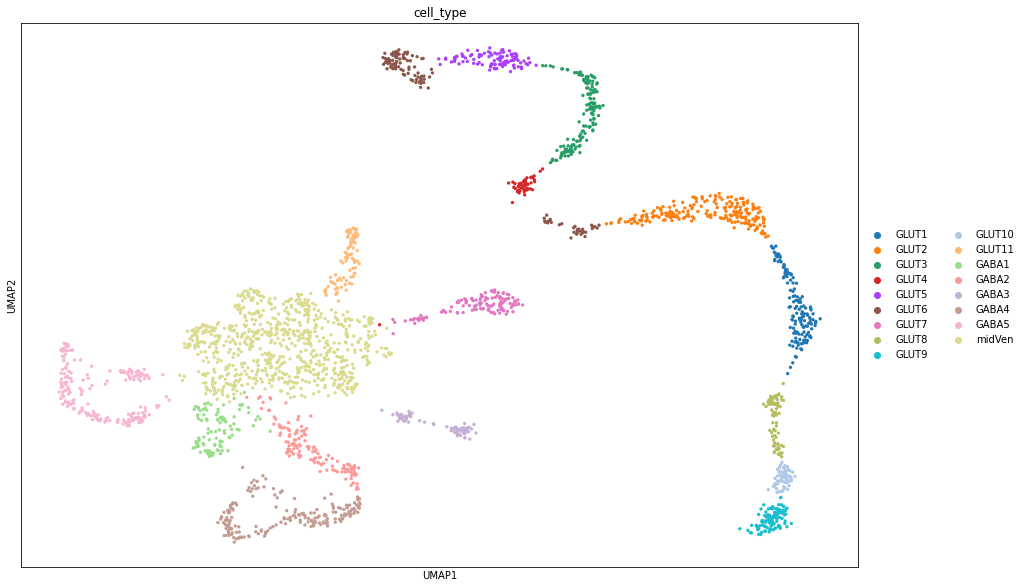

In [18]:
#curPlotFn = "/home/apfennin/projects/dorsalHorn/out31/macMarkerFig/nonSplitUMAP.3.1.1.1.pdf";
curPlotFn="nonSplitUMAP.3.1.1.1.pdf";
sc.pl.umap(dh_macCyn_neuron_ann, color='cell_type',save=curPlotFn)

In [19]:
#################################################
# Separate ADAMTS5-Rorb clusters #
#################################################

In [20]:
#Filter out the CSF neurons, not a part of the comparison
#≈ = dh_macCyn_neuron_ann[[curCell == "GABA4" or curCell == "GABA2" for curCell in dh_macCyn_neuron_ann.obs["cluster_type"]],:]

In [21]:
### Take a subset with only rorb/adamts5 ###
dh_macCynSub_neuron_ann = dh_macCyn_neuron_ann[[curCell == "GABA4" or curCell == "GABA2" for curCell in dh_macCyn_neuron_ann.obs["cell_type"]],:]


/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [22]:
#Plot key markers of the populations #

/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


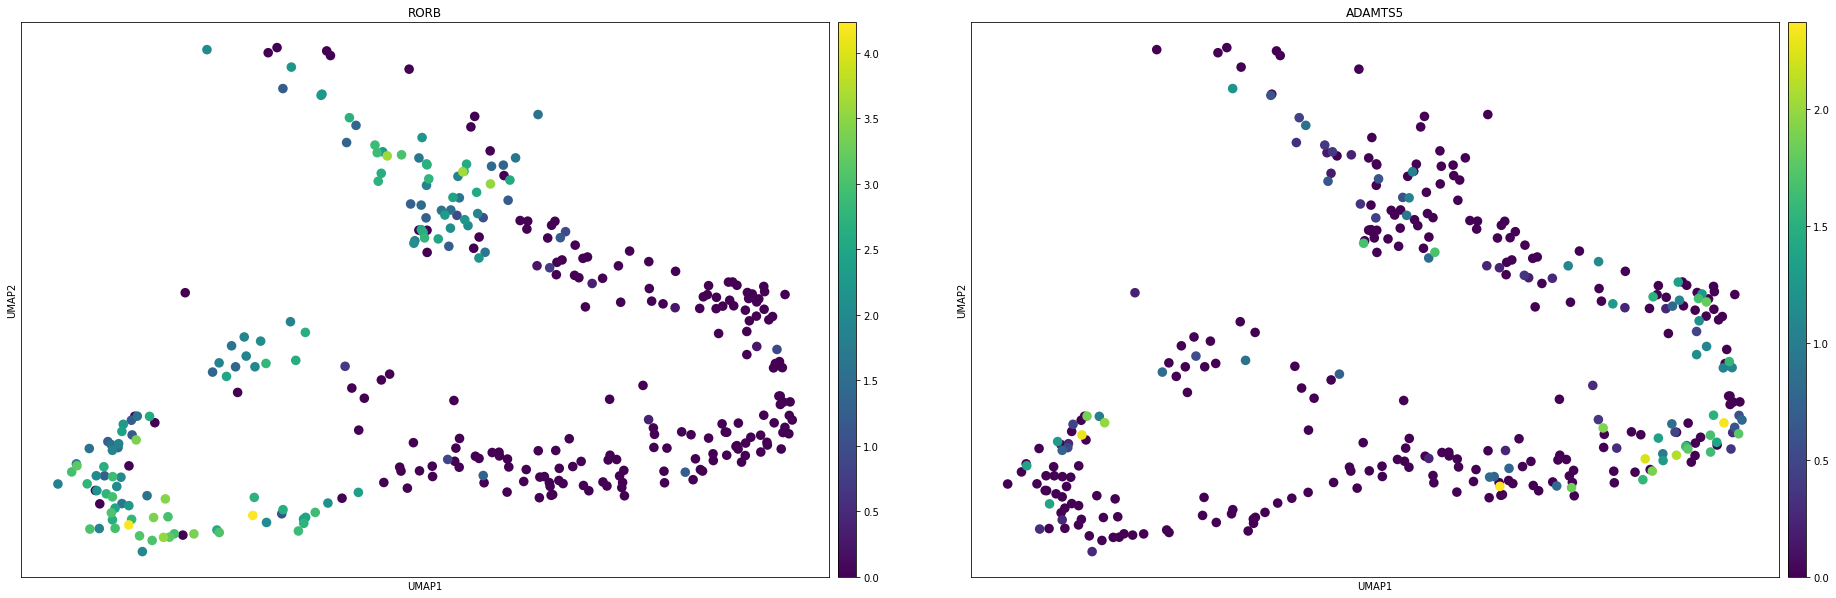

In [23]:
#curPlotFn = "/home/apfennin/projects/dorsalHorn/out11/macMarkerFig/cellClass.dorsal_excit_hex.1.6.1.pdf";
curPlotFn = "umap.macaque.gaba24.3.1.1.1.pdf";
#plt.savefig(curPlotFn)
sc.pl.umap(dh_macCynSub_neuron_ann, color=['RORB','ADAMTS5'],save=curPlotFn);

Trying to set attribute `.obs` of view, copying.


/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


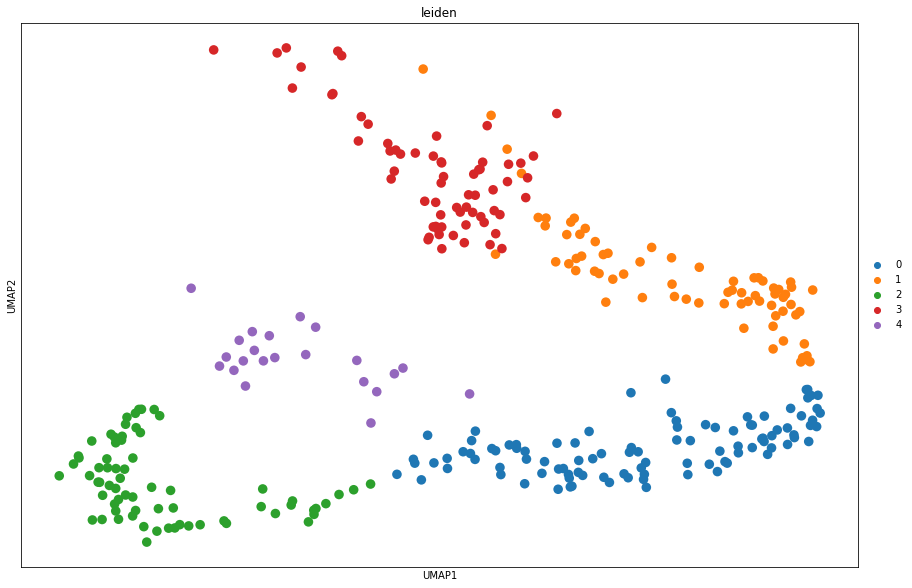

In [24]:
curPlotFn = "umap.macaque.gaba24.leiden.3.1.1.1.pdf";
sc.tl.leiden(dh_macCynSub_neuron_ann,resolution=0.3)
sc.pl.umap(dh_macCynSub_neuron_ann,color='leiden',save=curPlotFn);


In [73]:
#Create new object with additional categories
dh_macCyn2_neuron_ann = dh_macCyn_neuron_ann;
#dh_macCyn2_neuron_ann.obs['cell_type'].cat.categories

dh_macCyn2_neuron_ann.obs['cluster_type'] = dh_macCyn2_neuron_ann.obs['cell_type'].cat.set_categories(['GLUT1', 'GLUT2', 'GLUT3', 'GLUT4', 'GLUT5', 'GLUT6', 'GLUT7', 'GLUT8',
       'GLUT9', 'GLUT10', 'GLUT11', 'GABA1', 'GABA2_1', 'GABA2_2','GABA3', 'GABA4_1',
       'GABA4_2','GABA5','midVen'])

In [74]:
dh_macCyn2_neuron_ann.obs['cluster_type'].cat.categories

Index(['GLUT1', 'GLUT2', 'GLUT3', 'GLUT4', 'GLUT5', 'GLUT6', 'GLUT7', 'GLUT8',
       'GLUT9', 'GLUT10', 'GLUT11', 'GABA1', 'GABA2_1', 'GABA2_2', 'GABA3',
       'GABA4_1', 'GABA4_2', 'GABA5', 'midVen'],
      dtype='object')

/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


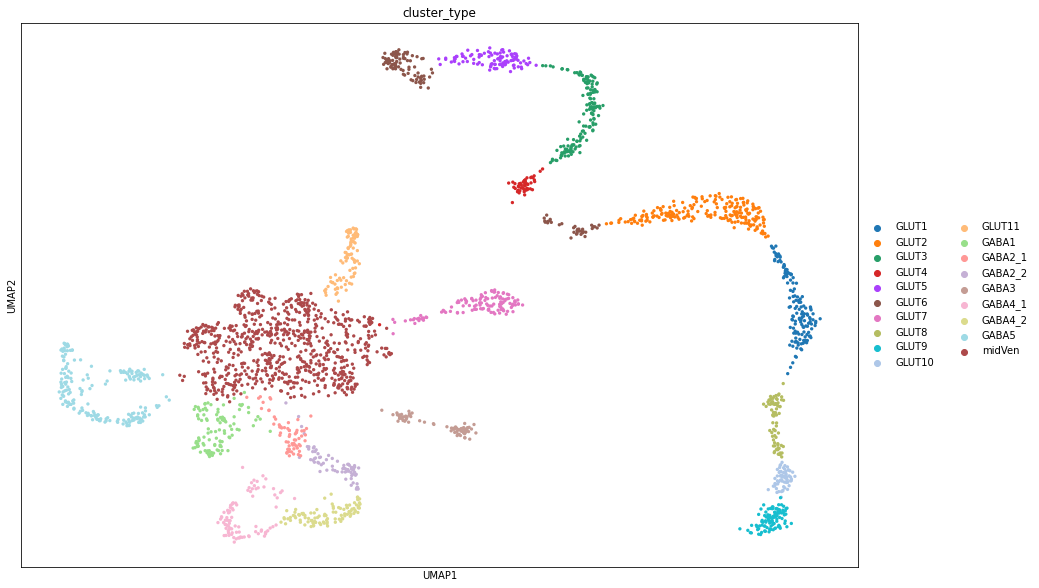

In [76]:
#Set new 'leiden 3' as GABA2_1; (Rorb)
newLeiden0V = dh_macCynSub_neuron_ann[[curCell == "3" for curCell in dh_macCynSub_neuron_ann.obs["leiden"]],:].obs.index
dh_macCyn2_neuron_ann.obs.loc[newLeiden0V,'cluster_type'] = "GABA2_1";

#Set new 'leiden 2' as GABA2_2; (Adamts5)
newLeiden0V = dh_macCynSub_neuron_ann[[curCell == "1" for curCell in dh_macCynSub_neuron_ann.obs["leiden"]],:].obs.index
dh_macCyn2_neuron_ann.obs.loc[newLeiden0V,'cluster_type'] = "GABA2_2"

#Set new 'leiden 4' as GABA4_1; (Rorb)
newLeiden0V = dh_macCynSub_neuron_ann[[curCell == "4" for curCell in dh_macCynSub_neuron_ann.obs["leiden"]],:].obs.index
dh_macCyn2_neuron_ann.obs.loc[newLeiden0V,'cluster_type'] = "GABA4_1"

#Set new 'leiden 2' as GABA4_1; (Rorb)
newLeiden0V = dh_macCynSub_neuron_ann[[curCell == "2" for curCell in dh_macCynSub_neuron_ann.obs["leiden"]],:].obs.index
dh_macCyn2_neuron_ann.obs.loc[newLeiden0V,'cluster_type'] = "GABA4_1"

#Set new 'leiden 0' as GABA4_2; (Adamts5)
newLeiden0V = dh_macCynSub_neuron_ann[[curCell == "0" for curCell in dh_macCynSub_neuron_ann.obs["leiden"]],:].obs.index
dh_macCyn2_neuron_ann.obs.loc[newLeiden0V,'cluster_type'] = "GABA4_2"

curPlotFn="macaqueSplitUMAP.3.1.1.1.pdf";
sc.pl.umap(dh_macCyn2_neuron_ann, color='cluster_type',save=curPlotFn)

#GABA2.1 and GABA4.1 are RORB1
#GABA2.2 and GABA4.2 are ADAMTS5



In [77]:
#Replace the original macaque object with the new one
dh_mac_neuron_ann = dh_macCyn2_neuron_ann;

In [78]:
#Write the h5ad file for the new macaque data, only do once
macSplit_neuron_h5ad_fn = "/home/apfennin/projects/dorsalHorn/rheMacData/macaque_integrated_famSplit.3.2.h5ad";

dh_macCyn2_neuron_ann.write_h5ad(macSplit_neuron_h5ad_fn); #Only do once


/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [29]:
#################################################
# Add new filtering and annotation info for the mouse clusters #
#################################################

In [30]:
############# Add annotation to the processed  clusters ################

In [30]:
#Filter out the CSF neurons, not a part of the comparison
mmDh_proc_neuron_2filt_ann = mmDh_proc_neuron_ann[[curCell != "CSF-cN" for curCell in mmDh_proc_neuron_ann.obs["final_cluster_assignment"]],:]

/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [31]:
#Read in the annotation info
ensInfo_hg_df = pd.read_csv("/home/apfennin/tools/ensv101/ens.hg38.geneInfo.v101.csv");
ensInfo_mm_df = pd.read_csv("/home/apfennin/tools/ensv101/ens.mm10.geneInfo.v101.csv");
ensInfo_hg2mm_df = pd.read_csv("/home/apfennin/tools/ensv101/ens.hg38_to_mm10.v101.csv");
levine2mm_df = pd.read_csv("/home/apfennin/projects/dorsalHorn/mmData/id_name_map.tsv",sep="\t");


In [32]:
#Add the mouse ensembl genes to the mouse object
mmGene2EnsD = {};
for index, row in levine2mm_df.iterrows():
    mmGene2EnsD[row['gene_name']] = row['gene_id'];
    
#mmDh_proc_neuron_2filt_ann.var["ens_gene_mm"] = [""]*len(mmDh_proc_neuron_2filt_ann.var.index)
mmEnsV = [];
for curId in mmDh_proc_neuron_2filt_ann.var.index.values.tolist() :
    if curId in mmGene2EnsD :
        mmEnsV.append(mmGene2EnsD[curId]);
    else :
        mmEnsV.append("");
mmDh_proc_neuron_2filt_ann.var["ens_gene_mm"] = mmEnsV;


Trying to set attribute `.var` of view, copying.


In [33]:
#Add the human ensembl genes to the mouse object
mmEns2HgEnsD = {};
for index, row in ensInfo_hg2mm_df.iterrows():
    if row['Mouse homology type'] == "ortholog_one2one" :
        mmEns2HgEnsD[row['Mouse gene stable ID']] = row['Gene stable ID'];
    
#mmDh_proc_neuron_2filt_ann.var["ens_gene_mm"] = [""]*len(mmDh_proc_neuron_2filt_ann.var.index)
hgEnsV = [];
for curId in mmDh_proc_neuron_2filt_ann.var["ens_gene_mm"].tolist() :
    if curId in mmEns2HgEnsD :
        hgEnsV.append(mmEns2HgEnsD[curId]);
    else :
        hgEnsV.append("");
mmDh_proc_neuron_2filt_ann.var["ens_gene_hg"] = hgEnsV;


In [34]:
#Add the human ensembl symbols to the mouse object
hgEns2SymD = {};
for index, row in ensInfo_hg_df.iterrows():
    if row['NCBI gene (formerly Entrezgene) accession'] != "NaN" :
        hgEns2SymD[row['Gene stable ID']] = row['NCBI gene (formerly Entrezgene) accession'];
    
#mmDh_proc_neuron_2filt_ann.var["ens_gene_mm"] = [""]*len(mmDh_proc_neuron_2filt_ann.var.index)
hgSymV = [];
for curId in mmDh_proc_neuron_2filt_ann.var["ens_gene_hg"].tolist() :
    if curId in hgEns2SymD :
        hgSymV.append(hgEns2SymD[curId]);
    else :
        hgSymV.append("");
        
mmDh_proc_neuron_2filt_ann.var["ncbi_sym_hg"] = hgSymV;


In [35]:
#Add new information about families of mouse clusters
mmClass2fam_df = pd.read_csv("/home/apfennin/projects/dorsalHorn/mmData/cluster_families.csv");
mmClust2famD = {};
for index, row in mmClass2fam_df.iterrows():
    mmClust2famD[row['cluster']] = row['family'];
#mmClust2famD
mmDh_proc_neuron_2filt_ann.obs["family"] = [mmClust2famD[curCell] for curCell in mmDh_proc_neuron_2filt_ann.obs["final_cluster_assignment"]]

In [36]:
mmClass2fam_df

,cluster,family
0,OPC,OPC
1,Oligo Progen 1,Oligo Progen 1
2,Oligo Progen 2,Oligo Progen 2
3,Oligos 1,Oligos 1
4,Oligos 2,Oligos 2
...,...,...
79,Inhib-23,VI
80,Inhib-24,VI
81,Inhib-25,VI
82,Inhib-26,VI


In [37]:
#Read in the mouse cluster order, comes from Ariel Levine
mmClustOrdFn = "/home/apfennin/projects/dorsalHorn/mmData/clusterOrder.mm.2.csv";
#mmClustOrdF = open(mmClustOrdFn,"r");
mmClustOrdD = {};
mmFullClustOrdV = [];
curClustNum = 0;
for curLine in fileinput.input([mmClustOrdFn]) :
    curClustName = curLine.rstrip();
    mmClustOrdD[curClustName] = curClustNum;
    mmFullClustOrdV.append(curClustName);
    
    curClustNum = curClustNum + 1;
    
#mmClustOrdF.close();

#mmFullClustOrdV

In [38]:
#Filter macaque genes to only be those that overlap mouse
macGeneV = dh_mac_neuron_ann.var.index.tolist();
mmDh_proc_neuron_3filt_ann = mmDh_proc_neuron_2filt_ann[:,[curGene in macGeneV for curGene in mmDh_proc_neuron_2filt_ann.var["ncbi_sym_hg"]]]

/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [39]:
#Create variable names with the symbols
mmDh_proc_neuron_3filt_ann.var["mm_sym"] = mmDh_proc_neuron_3filt_ann.var.index.tolist()
mmDh_proc_neuron_3filt_ann.var.index = mmDh_proc_neuron_3filt_ann.var["ncbi_sym_hg"]
mmDh_proc_neuron_3filt_ann.var

Trying to set attribute `.var` of view, copying.


,Selected,ens_gene_mm,ens_gene_hg,ncbi_sym_hg,mm_sym
ncbi_sym_hg,,,,,
NPY,1.0,ENSMUSG00000029819,ENSG00000122585,NPY,Npy
PKD1L2,1.0,ENSMUSG00000034416,ENSG00000166473,PKD1L2,Pkd1l2
SST,1.0,ENSMUSG00000004366,ENSG00000157005,SST,Sst
TAC1,1.0,ENSMUSG00000061762,ENSG00000006128,TAC1,Tac1
CRABP1,1.0,ENSMUSG00000032291,ENSG00000166426,CRABP1,Crabp1
...,...,...,...,...,...
NDN,1.0,ENSMUSG00000033585,ENSG00000182636,NDN,Ndn
FYB1,1.0,ENSMUSG00000022148,ENSG00000082074,FYB1,Fyb
C12orf75,1.0,ENSMUSG00000087651,ENSG00000235162,C12orf75,1500009L16Rik


In [41]:
############# Add annotation to the raw  clusters ################

In [42]:
#Port cell annotations over from raw to processed mouse
#Filter out cells that aren't informative
mmDh_raw_neuron_reord_ann = mmDh_raw_neuron_ann[mmDh_proc_neuron_3filt_ann.obs.index]
mmDh_raw_neuron_reord_ann.obs = mmDh_proc_neuron_3filt_ann.obs
mmDh_raw_neuron_reord_ann

AnnData object with n_obs × n_vars = 18816 × 27985
    obs: 'ClusterID', 'ClusterName', 'coarse_cell_types', 'dataset', 'final_cluster_assignment', 'nCount_RNA', 'nFeature_RNA', 'orig_ident', 'percent_mt', 'family'
    layers: 'norm_data'

In [44]:
mmRawEnsV = [];
for curId in mmDh_raw_neuron_reord_ann.var.index.values.tolist() :
    if curId in mmGene2EnsD :
        mmRawEnsV.append(mmGene2EnsD[curId]);
    else :
        mmRawEnsV.append("");
mmDh_raw_neuron_reord_ann.var["ens_gene_mm"] = mmRawEnsV;
#mmDh_raw_neuron_reord_ann.var


In [45]:
#Add the human ensembl genes to the mouse object

hgEnsRawV = [];
for curId in mmDh_raw_neuron_reord_ann.var["ens_gene_mm"].tolist() :
    if curId in mmEns2HgEnsD :
        hgEnsRawV.append(mmEns2HgEnsD[curId]);
    else :
        hgEnsRawV.append("");
mmDh_raw_neuron_reord_ann.var["ens_gene_hg"] = hgEnsRawV;
mmDh_raw_neuron_reord_ann.var


,ens_gene_mm,ens_gene_hg
Xkr4,ENSMUSG00000051951,ENSG00000206579
Gm1992,ENSMUSG00000089699,
Gm37381,ENSMUSG00000102343,
Rp1,ENSMUSG00000109048,
Rp1.1,,
...,...,...
AC168977.1,ENSMUSG00000079808,
PISD,ENSMUSG00000095041,
DHRSX,ENSMUSG00000063897,
Vmn2r122,ENSMUSG00000096730,


In [46]:
#Add the human ensembl symbols to the mouse object

hgSymRawV = [];
for curId in mmDh_raw_neuron_reord_ann.var["ens_gene_hg"].tolist() :
    if curId in hgEns2SymD :
        hgSymRawV.append(hgEns2SymD[curId]);
    else :
        hgSymRawV.append("");
        
mmDh_raw_neuron_reord_ann.var["ncbi_sym_hg"] = hgSymRawV;
mmDh_raw_neuron_reord_ann.var


,ens_gene_mm,ens_gene_hg,ncbi_sym_hg
Xkr4,ENSMUSG00000051951,ENSG00000206579,XKR4
Gm1992,ENSMUSG00000089699,,
Gm37381,ENSMUSG00000102343,,
Rp1,ENSMUSG00000109048,,
Rp1.1,,,
...,...,...,...
AC168977.1,ENSMUSG00000079808,,
PISD,ENSMUSG00000095041,,
DHRSX,ENSMUSG00000063897,,
Vmn2r122,ENSMUSG00000096730,,


In [47]:
#Filter macaque genes to only be those that overlap mouse (bigger list)
#macGeneV = dh_mac_neuron_ann.var.index.tolist();
mmDh_raw_neuron_2reordFilt_ann = mmDh_raw_neuron_reord_ann[:,[curGene in macGeneV for curGene in mmDh_raw_neuron_reord_ann.var["ncbi_sym_hg"]]]

/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [48]:
mmDh_raw_neuron_reord_ann

AnnData object with n_obs × n_vars = 18816 × 27985
    obs: 'ClusterID', 'ClusterName', 'coarse_cell_types', 'dataset', 'final_cluster_assignment', 'nCount_RNA', 'nFeature_RNA', 'orig_ident', 'percent_mt', 'family'
    var: 'ens_gene_mm', 'ens_gene_hg', 'ncbi_sym_hg'
    layers: 'norm_data'

In [49]:
mmDh_raw_neuron_2reordFilt_ann

View of AnnData object with n_obs × n_vars = 18816 × 15157
    obs: 'ClusterID', 'ClusterName', 'coarse_cell_types', 'dataset', 'final_cluster_assignment', 'nCount_RNA', 'nFeature_RNA', 'orig_ident', 'percent_mt', 'family'
    var: 'ens_gene_mm', 'ens_gene_hg', 'ncbi_sym_hg'
    layers: 'norm_data'

In [50]:
#Create variable names with the symbols
mmDh_raw_neuron_2reordFilt_ann.var["mm_sym"] = mmDh_raw_neuron_2reordFilt_ann.var.index.tolist()
mmDh_raw_neuron_2reordFilt_ann.var.index = mmDh_raw_neuron_2reordFilt_ann.var["ncbi_sym_hg"]
mmDh_raw_neuron_2reordFilt_ann.var

Trying to set attribute `.var` of view, copying.


,ens_gene_mm,ens_gene_hg,ncbi_sym_hg,mm_sym
ncbi_sym_hg,,,,
XKR4,ENSMUSG00000051951,ENSG00000206579,XKR4,Xkr4
SOX17,ENSMUSG00000025902,ENSG00000164736,SOX17,Sox17
MRPL15,ENSMUSG00000033845,ENSG00000137547,MRPL15,Mrpl15
LYPLA1,ENSMUSG00000025903,ENSG00000120992,LYPLA1,Lypla1
TCEA1,ENSMUSG00000033813,ENSG00000187735,TCEA1,Tcea1
...,...,...,...,...
PRDX3,ENSMUSG00000024997,ENSG00000165672,PRDX3,Prdx3
GRK5,ENSMUSG00000003228,ENSG00000198873,GRK5,Grk5
SPRY3,ENSMUSG00000061654,ENSG00000168939,SPRY3,Spry3


In [51]:
mmDh_raw_neuron_2reordFilt_ann.obs

,ClusterID,ClusterName,coarse_cell_types,dataset,final_cluster_assignment,nCount_RNA,nFeature_RNA,orig_ident,percent_mt,family
SRR6040902_ACTTCGTCTTAA,65,Inhib-16,Neuron,Sathyamurthy,Inhib-16,12470.0,3760.0,SRR6040902,0.000160,MI
SRR6040902_ATTGTACTGGTA,84,Inhib-27,Neuron,Sathyamurthy,Inhib-27,7971.0,2900.0,SRR6040902,0.000376,VI
SRR6040902_TGTCCAAGAATA,56,Excit-23,Neuron,Sathyamurthy,Excit-23,1452.0,898.0,SRR6040902,0.004798,Lmx1b/ME
SRR6040902_GTAGCTGGGGCN,35,Excit-16,Neuron,Sathyamurthy,Excit-16,971.0,585.0,SRR6040902,0.000000,Sox5
SRR6040902_CTTTTTGCCTGG,40,Inhib-01,Neuron,Sathyamurthy,Inhib-01,8375.0,2975.0,SRR6040902,0.000358,Rorb
...,...,...,...,...,...,...,...,...,...,...
SRR8956045_GGAACTAC,74,Excit-34,Neuron,Baek,Excit-34,165497.0,6548.0,SRR8956045,0.025152,VE
SRR8956045_TTAGAAGT,75,Excit-35,Neuron,Baek,Excit-35,267163.0,8626.0,SRR8956045,0.040452,VE
SRR8956045_GACTGTAT,48,Inhib-09,Neuron,Baek,Inhib-09,107366.0,5698.0,SRR8956045,0.018215,Pdyn
SRR8956045_GCAACTCC,48,Inhib-09,Neuron,Baek,Inhib-09,101163.0,5436.0,SRR8956045,0.014467,Pdyn


In [53]:
satRowBV = mmDh_raw_neuron_2reordFilt_ann.obs["dataset"] == "Sathyamurthy"

In [54]:
#Subset of mouse to only include adult
#mmDh_raw_neuron_3adultFilt_ann = mmDh_raw_neuron_2reordFilt_ann[satRowB2V,:]
mmDh_raw_neuron_3adultFilt_ann = mmDh_raw_neuron_2reordFilt_ann[satRowBV]
mmDh_raw_neuron_3adultFilt_ann

/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 5393 × 15157
    obs: 'ClusterID', 'ClusterName', 'coarse_cell_types', 'dataset', 'final_cluster_assignment', 'nCount_RNA', 'nFeature_RNA', 'orig_ident', 'percent_mt', 'family'
    var: 'ens_gene_mm', 'ens_gene_hg', 'ncbi_sym_hg', 'mm_sym'
    layers: 'norm_data'

In [55]:
mmDh_raw_neuron_2reordFilt_ann

AnnData object with n_obs × n_vars = 18816 × 15157
    obs: 'ClusterID', 'ClusterName', 'coarse_cell_types', 'dataset', 'final_cluster_assignment', 'nCount_RNA', 'nFeature_RNA', 'orig_ident', 'percent_mt', 'family'
    var: 'ens_gene_mm', 'ens_gene_hg', 'ncbi_sym_hg', 'mm_sym'
    layers: 'norm_data'

In [55]:
#################################################
# Compare mouse clusters to macaque cells #
#################################################

In [57]:
############ Calculate the differential gene expression for each of the mouse clusters ###############

In [56]:
#Annotate the mouse clusters based on the major cell class
#This version, remove excit-25
#mmCellClassV = ['dorsal_excit','dorsal_inhib','midVent','CSF-cN'];
mmCellClassV = ['dorsal_excit','dorsal_inhib','midVent'];
mmClass2clustD = {};
#mmClass2clustD["dorsal_excit"] = ["Excit-0" + str(curNum+1)  for curNum in range(9)] + ["Excit-" + str(curNum+1)  for curNum in range(9,19)] + ["Excit-25"];
mmClass2clustD["dorsal_excit"] = ["Excit-0" + str(curNum+1)  for curNum in range(9)] + ["Excit-" + str(curNum+1)  for curNum in range(9,19)];
mmClass2clustD["dorsal_inhib"] = ["Inhib-0" + str(curNum+1)  for curNum in range(9)] + ["Inhib-" + str(curNum+1)  for curNum in range(9,13)];
#mmClass2clustD["CSF-cN"] = ["CSF-cN"];

allClustV = mmDh_proc_neuron_3filt_ann.obs["final_cluster_assignment"].unique().tolist()
mmClass2clustD["midVent"] = list(set(allClustV) - set(mmClass2clustD["dorsal_excit"] + mmClass2clustD["dorsal_inhib"]));

mmClust2classD = {};
for curKey in mmClass2clustD :
    for curClust in mmClass2clustD[curKey] :
        mmClust2classD[curClust] = curKey;
#mmClust2classD

In [57]:
#The major mouse set to do for most comparisons
mmDh_proc_neuron_3filt_ann.obs["cell_class"] = [mmClust2classD[curClust] for curClust in mmDh_proc_neuron_3filt_ann.obs["final_cluster_assignment"]]

#The major mouse set to do for quantiative specificity experiments
mmDh_raw_neuron_3adultFilt_ann.obs["cell_class"] = [mmClust2classD[curClust] for curClust in mmDh_raw_neuron_3adultFilt_ann.obs["final_cluster_assignment"]]

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [58]:
mmDh_raw_neuron_3adultFilt_ann.obs

,ClusterID,ClusterName,coarse_cell_types,dataset,final_cluster_assignment,nCount_RNA,nFeature_RNA,orig_ident,percent_mt,family,cell_class
SRR6040902_ACTTCGTCTTAA,65,Inhib-16,Neuron,Sathyamurthy,Inhib-16,12470.0,3760.0,SRR6040902,0.000160,MI,midVent
SRR6040902_ATTGTACTGGTA,84,Inhib-27,Neuron,Sathyamurthy,Inhib-27,7971.0,2900.0,SRR6040902,0.000376,VI,midVent
SRR6040902_TGTCCAAGAATA,56,Excit-23,Neuron,Sathyamurthy,Excit-23,1452.0,898.0,SRR6040902,0.004798,Lmx1b/ME,midVent
SRR6040902_GTAGCTGGGGCN,35,Excit-16,Neuron,Sathyamurthy,Excit-16,971.0,585.0,SRR6040902,0.000000,Sox5,dorsal_excit
SRR6040902_CTTTTTGCCTGG,40,Inhib-01,Neuron,Sathyamurthy,Inhib-01,8375.0,2975.0,SRR6040902,0.000358,Rorb,dorsal_inhib
...,...,...,...,...,...,...,...,...,...,...,...
SRR6498362_ATAATCCCAACT,40,Inhib-01,Neuron,Sathyamurthy,Inhib-01,1623.0,1016.0,SRR6498362,0.000000,Rorb,dorsal_inhib
SRR6498362_CAATTACTCGTG,27,Excit-08,Neuron,Sathyamurthy,Excit-08,4211.0,1684.0,SRR6498362,0.003314,Reln,dorsal_excit
SRR6498362_GTGCAAAGGCTG,65,Inhib-16,Neuron,Sathyamurthy,Inhib-16,4436.0,1925.0,SRR6498362,0.003146,MI,midVent
SRR6498362_ATGTTGGGGGAG,40,Inhib-01,Neuron,Sathyamurthy,Inhib-01,872.0,598.0,SRR6498362,0.004566,Rorb,dorsal_inhib


In [60]:
#Write the h5ad file for the new mouse data, only do once
#sc.pl.umap(dh_mac_neuron_mmComp_ann, color='mouse_family')

mmSplitComp_adult_comp_h5ad_fn = "/home/apfennin/projects/dorsalHorn/mmData/mmData.comp.adult.h5ad";
#mmDh_raw_neuron_3adultFilt_ann.write_h5ad(mmSplitComp_adult_comp_h5ad_fn); #Only do once
#tmp_ann.var.drop("ncbi_sym_hg", axis='columns', inplace=True);


mmSplitComp_fullDev_comp_h5ad_fn = "/home/apfennin/projects/dorsalHorn/mmData/mmData.comp.fullDev.h5ad";
mmDh_raw_neuron_2reordFilt_ann.var.drop("ncbi_sym_hg", axis='columns', inplace=True);
#mmDh_raw_neuron_2reordFilt_ann.write_h5ad(mmSplitComp_fullDev_comp_h5ad_fn); #Only do once
#mmDh_raw_neuron_2reordFilt_ann


In [63]:
#Create subsets of the ann data for each cell class - integrated
annSubsetMmD = {};
for curClass in ['dorsal_excit','dorsal_inhib','midVent'] :
    annSubsetMmD[curClass] = mmDh_proc_neuron_3filt_ann[mmDh_proc_neuron_3filt_ann.obs["cell_class"] == curClass];


/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [64]:
#Create subsets of the ann data for each cell class - raw
annSubsetRawMmD = {};
for curClass in ['dorsal_excit','dorsal_inhib','midVent'] :
    annSubsetRawMmD[curClass] = mmDh_raw_neuron_3adultFilt_ann[mmDh_raw_neuron_3adultFilt_ann.obs["cell_class"] == curClass];


In [65]:
#Calculate wilcox rank for each mouse cluster - integrated
sc.tl.rank_genes_groups(mmDh_proc_neuron_3filt_ann, 'cell_class', method='wilcoxon',rankby_abs=False)

/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'family' as categorical
... storing 'cell_class' as categorical
/home/apfennin/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:407: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


In [66]:
#Calculate wilcox rank for each mouse cluster - integrated, subgroups
for curClass in annSubsetMmD :
    sc.tl.rank_genes_groups(annSubsetMmD[curClass], 'final_cluster_assignment', method='wilcoxon',rankby_abs=False)


/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'family' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_class' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'family' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_class' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'family' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_class' as categorical


In [67]:
#Calculate wilcox rank for each mouse cluster - raw
sc.tl.rank_genes_groups(mmDh_raw_neuron_3adultFilt_ann, 'cell_class', method='wilcoxon',rankby_abs=False)

In [68]:
#Calculate wilcox rank for each mouse cluster - raw, subgroups
#for curClass in annSubsetRawMmD :
#sc.tl.rank_genes_groups(annSubsetRawMmD[curClass], 'final_cluster_assignment', method='wilcoxon',rankby_abs=False)

sc.tl.rank_genes_groups(annSubsetRawMmD['dorsal_excit'], 'family', method='wilcoxon',rankby_abs=False)
sc.tl.rank_genes_groups(annSubsetRawMmD['dorsal_inhib'], 'family', method='wilcoxon',rankby_abs=False)


Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [69]:
#Plot wilcox rank for each mouse cluster
#sc.settings.figdir = "/home/apfennin/projects/dorsalHorn/out21/mmMarkerFig/";
#sc.pl.rank_genes_groups(mmDh_proc_neuron_3filt_ann, n_genes=25, sharey=False,save='.pdf')


In [70]:
################ Calculate the macaque differential gene expression ##############

In [79]:
#Use the mouse ordering for the genes
#dh_mac_neuron_mmComp_ann = dh_mac_neuron_ann[:,macMmCommonSymV]
#dh_mac_neuron_mmComp_ann = dh_mac_neuron_ann[:,mmDh_raw_neuron_2reordFilt_ann.var.index]
#Now updated with cynthia's new object, split RORB/ADAMTS5
dh_mac_neuron_mmComp_ann = dh_mac_neuron_ann[:,mmDh_raw_neuron_2reordFilt_ann.var.index]


/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [80]:
dh_mac_neuron_mmComp_ann

View of AnnData object with n_obs × n_vars = 2698 × 15157
    obs: 'Barcode', 'Unnamed..0', 'Sample', 'cxds_score', 'bcds_score', 'hybrid_score', 'precluster', 'nUMI', 'nGene', 'sample_short', 'unique_id', 'precluster_sample', 'size_factor', 'leiden', 'clust_2', 'cell_type', 'cluster_type'
    uns: 'cell_type_colors', 'clust_2_colors', 'dendrogram_leiden', 'leiden', 'neighbors', 'sample_short_colors', 'umap', 'cluster_type_colors'
    obsm: 'X_pca', 'X_umap', 'scanorama'
    obsp: 'connectivities', 'distances'

In [81]:
dh_mac_neuron_mmComp_ann.obs

,Barcode,Unnamed..0,Sample,cxds_score,bcds_score,hybrid_score,precluster,nUMI,nGene,sample_short,unique_id,precluster_sample,size_factor,leiden,clust_2,cell_type,cluster_type
1,AAACCCAAGGATACGC,1,/projects/pfenninggroup/machineLearningForComp...,151402.545658,0.102375,0.258838,8,16448,5536,P0,AAACCCAAGGATACGC_P0,8_P0,3.717381,10,28,GLUT6,GLUT6
2,AAACCCAAGTAGGTTA,2,/projects/pfenninggroup/machineLearningForComp...,207183.175964,0.077937,0.303326,2,25551,7119,P0,AAACCCAAGTAGGTTA_P0,2_P0,5.914232,11,6,GABA1,GABA1
4,AAACGAAAGGTGATAT,4,/projects/pfenninggroup/machineLearningForComp...,126728.563342,0.045736,0.165572,11,19303,6062,P0,AAACGAAAGGTGATAT_P0,11_P0,4.297744,3,26,GABA5,GABA5
5,AAACGAAGTACCAATC,5,/projects/pfenninggroup/machineLearningForComp...,345115.402180,0.333406,0.757984,9,21247,6543,P0,AAACGAAGTACCAATC_P0,9_P0,5.002229,7,11,GLUT1,GLUT1
7,AAACGAAGTCCTACGG,7,/projects/pfenninggroup/machineLearningForComp...,224653.492697,0.294197,0.561554,2,24462,7545,P0,AAACGAAGTCCTACGG_P0,2_P0,6.251272,0,21,midVen,midVen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12210,TTTCACAAGGGACTGT,4322,/projects/pfenninggroup/machineLearningForComp...,283180.343375,0.005369,0.118701,5,2143,1375,P3,TTTCACAAGGGACTGT_P3,5_P3,0.431840,2,4,GLUT2,GLUT2
12221,TTTCCTCTCTAACGCA,4335,/projects/pfenninggroup/machineLearningForComp...,520752.778456,0.045209,0.276369,5,5231,2667,P3,TTTCCTCTCTAACGCA_P3,5_P3,1.103523,2,4,GLUT2,GLUT2
12228,TTTGACTGTCGAAACG,4342,/projects/pfenninggroup/machineLearningForComp...,623896.667089,0.044241,0.326314,3,4566,2609,P3,TTTGACTGTCGAAACG_P3,3_P3,1.029808,0,6,midVen,midVen
12232,TTTGGAGCAGTGCGCT,4346,/projects/pfenninggroup/machineLearningForComp...,570703.381288,0.046168,0.302003,5,3974,2120,P3,TTTGGAGCAGTGCGCT_P3,5_P3,0.787932,5,12,GLUT9,GLUT9


In [175]:
#Add macaque family information, precomputed
mac2mmclassD = {};


mac2mmclassD['GLUT1'] = 'dorsal_excit';
mac2mmclassD['GLUT2'] = 'dorsal_excit';
mac2mmclassD['GLUT3'] = 'dorsal_excit';
mac2mmclassD['GLUT4'] = 'dorsal_excit';
mac2mmclassD['GLUT5'] = 'dorsal_excit';
mac2mmclassD['GLUT6'] = 'dorsal_excit';
mac2mmclassD['GLUT7'] = 'dorsal_excit';
mac2mmclassD['GLUT8'] = 'dorsal_excit';
mac2mmclassD['GLUT9'] = 'dorsal_excit';
mac2mmclassD['GLUT10'] = 'dorsal_excit';
mac2mmclassD['GLUT11'] = 'dorsal_excit';

mac2mmclassD['GABA1'] = 'dorsal_inhib';
mac2mmclassD['GABA2_1'] = 'dorsal_inhib';
mac2mmclassD['GABA2_2'] = 'dorsal_inhib';
mac2mmclassD['GABA3'] = 'dorsal_inhib';
mac2mmclassD['GABA4_1'] = 'dorsal_inhib';
mac2mmclassD['GABA4_2'] = 'dorsal_inhib';
mac2mmclassD['GABA5'] = 'dorsal_inhib';

mac2mmclassD['midVen'] = 'midVent';

dh_mac_neuron_mmComp_ann.obs["mouse_class"] = [mac2mmclassD[curClust] for curClust in dh_mac_neuron_mmComp_ann.obs["cluster_type"]]
#dh_mac_neuron_mmComp_ann.obs

dh_mac_neuron_ann.obs["mouse_class"] = [mac2mmclassD[curClust] for curClust in dh_mac_neuron_ann.obs["cluster_type"]]
dh_mac_neuron_ann.obs

,Barcode,Unnamed..0,Sample,cxds_score,bcds_score,hybrid_score,precluster,nUMI,nGene,sample_short,unique_id,precluster_sample,size_factor,leiden,clust_2,cell_type,cluster_type,pred_mm_class_label,mouse_class
1,AAACCCAAGGATACGC,1,/projects/pfenninggroup/machineLearningForComp...,151402.545658,0.102375,0.258838,8,16448,5536,P0,AAACCCAAGGATACGC_P0,8_P0,3.717381,10,28,GLUT6,GLUT6,dorsal_excit,dorsal_excit
2,AAACCCAAGTAGGTTA,2,/projects/pfenninggroup/machineLearningForComp...,207183.175964,0.077937,0.303326,2,25551,7119,P0,AAACCCAAGTAGGTTA_P0,2_P0,5.914232,11,6,GABA1,GABA1,dorsal_inhib,dorsal_inhib
4,AAACGAAAGGTGATAT,4,/projects/pfenninggroup/machineLearningForComp...,126728.563342,0.045736,0.165572,11,19303,6062,P0,AAACGAAAGGTGATAT_P0,11_P0,4.297744,3,26,GABA5,GABA5,midVent,dorsal_inhib
5,AAACGAAGTACCAATC,5,/projects/pfenninggroup/machineLearningForComp...,345115.402180,0.333406,0.757984,9,21247,6543,P0,AAACGAAGTACCAATC_P0,9_P0,5.002229,7,11,GLUT1,GLUT1,midVent,dorsal_excit
7,AAACGAAGTCCTACGG,7,/projects/pfenninggroup/machineLearningForComp...,224653.492697,0.294197,0.561554,2,24462,7545,P0,AAACGAAGTCCTACGG_P0,2_P0,6.251272,0,21,midVen,midVen,midVent,midVent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12210,TTTCACAAGGGACTGT,4322,/projects/pfenninggroup/machineLearningForComp...,283180.343375,0.005369,0.118701,5,2143,1375,P3,TTTCACAAGGGACTGT_P3,5_P3,0.431840,2,4,GLUT2,GLUT2,dorsal_excit,dorsal_excit
12221,TTTCCTCTCTAACGCA,4335,/projects/pfenninggroup/machineLearningForComp...,520752.778456,0.045209,0.276369,5,5231,2667,P3,TTTCCTCTCTAACGCA_P3,5_P3,1.103523,2,4,GLUT2,GLUT2,dorsal_excit,dorsal_excit
12228,TTTGACTGTCGAAACG,4342,/projects/pfenninggroup/machineLearningForComp...,623896.667089,0.044241,0.326314,3,4566,2609,P3,TTTGACTGTCGAAACG_P3,3_P3,1.029808,0,6,midVen,midVen,dorsal_inhib,midVent
12232,TTTGGAGCAGTGCGCT,4346,/projects/pfenninggroup/machineLearningForComp...,570703.381288,0.046168,0.302003,5,3974,2120,P3,TTTGGAGCAGTGCGCT_P3,5_P3,0.787932,5,12,GLUT9,GLUT9,dorsal_excit,dorsal_excit


In [89]:
sc.tl.rank_genes_groups(dh_mac_neuron_mmComp_ann, 'mouse_class', method='wilcoxon',rankby_abs=False)

/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'mouse_class' as categorical


In [92]:
#Create subsets of the ann data for each cell class - integrated
annSubsetMacFiltD = {};
for curClass in ['dorsal_excit','dorsal_inhib','midVent'] :
    annSubsetMacFiltD[curClass] = dh_mac_neuron_mmComp_ann[dh_mac_neuron_mmComp_ann.obs["mouse_class"] == curClass];


In [79]:
################## Annotate each macaque cell/cluster based on mouse annotatations ##################

In [153]:
#Exp_df - data frame of full cell expression object
#sif_df - data frame of significantly differential genes

def sig_score(exp_df,sig_df):
    full_gene_set = set(exp_df.columns.values)
    
    upreg_genes = sig_df[sig_df.scores>0].index.values
    #upreg_genes_cap = [gene.capitalize() for gene in upreg_genes]
    message = "Number of total upregulated genes:" + str(len(upreg_genes))
    #print(message)
    upreg_inter = list(full_gene_set.intersection(set(upreg_genes)))
    message = "Number of found upregulated genes:" + str(len(upreg_inter))
    #print(message)
    upreg_vals = exp_df[upreg_inter];
    upreg_vals = upreg_vals.sparse.to_dense();
    #print(upreg_vals)
    upreg_vals = scale(upreg_vals)
    upreg_score = np.sum(upreg_vals,axis=1)
    
    downreg_genes = sig_df[sig_df.scores<0].index.values
    #downreg_genes_cap = [gene.capitalize() for gene in downreg_genes]
    message = "Number of total downregulated genes:" + str(len(downreg_genes))
    #print(message)
    downreg_inter = list(full_gene_set.intersection(set(downreg_genes)))
    message = "Number of found downregulated genes:" + str(len(downreg_inter))
    #print(message)

    downreg_vals = exp_df[downreg_inter]
    downreg_vals = downreg_vals.sparse.to_dense();
    downreg_vals = scale(downreg_vals)
    downreg_score = np.sum(downreg_vals,axis=1)
    return upreg_score-downreg_score
    #return (upreg_score-downreg_score)/(len(upreg_inter)+len(downreg_inter))


In [120]:
#dh_mac_neuron_ann.X #(2698x54894 matrix)
#dh_mac_neuron_ann.obs.index #Length 2698
#dh_mac_neuron_ann.var_names #Length 54894

<2698x15157 sparse matrix of type '<class 'numpy.float32'>'
	with 7900017 stored elements in Compressed Sparse Row format>

In [118]:
#dh_mac_neuron_exp_df = pd.DataFrame(data=dh_mac_neuron_ann.X,index=dh_mac_neuron_ann.obs.index.values,columns=dh_mac_neuron_ann.var_names.values)
dh_mac_neuron_exp_df = pd.DataFrame.sparse.from_spmatrix(data=dh_mac_neuron_ann.X,index=dh_mac_neuron_ann.obs.index.values,columns=dh_mac_neuron_ann.var_names.values)

In [154]:
#Loop through each mouse cluster to calculate the score for each macaque cell
#Use 100 markers for larger classes
numMarkers = 100;

sigScoreFullD = {};
curMm_ann = mmDh_proc_neuron_3filt_ann;
curGeneLen = len(curMm_ann.uns['rank_genes_groups']["scores"])

for curMmClass in mmCellClassV :
    curMmClass_sigDict = {};
    curMmClass_sigDict["names"] = curMm_ann.uns['rank_genes_groups']["names"][curMmClass][0:numMarkers].tolist();
    curMmClass_sigDict["scores"] = curMm_ann.uns['rank_genes_groups']["scores"][curMmClass][0:numMarkers].tolist();

    curMmClass_sigDict["names"] = curMmClass_sigDict["names"] + curMm_ann.uns['rank_genes_groups']["names"][curMmClass][(curGeneLen-numMarkers):curGeneLen].tolist();
    curMmClass_sigDict["scores"] = curMmClass_sigDict["scores"] + curMm_ann.uns['rank_genes_groups']["scores"][curMmClass][(curGeneLen-numMarkers):curGeneLen].tolist();
        
    #curMmClass_sigDict["names_cap"] = [gene.upper() for gene in curMmClass_sigDict["names"]] 
    curMmClass_sigDict["names_use"] = curMmClass_sigDict["names"];
    curMmClass_sigDf = pd.DataFrame(data=curMmClass_sigDict,index=curMmClass_sigDict["names_use"]);
    #print(curMmClust_sigDf);
    
    sigScoreFullD[curMmClass] = sig_score(dh_mac_neuron_exp_df,curMmClass_sigDf);
    #stophere();
    
#Add the best mouse annotation to each macaque subtype    
curMm2macSigScoreFull_df = pd.DataFrame(data=sigScoreFullD,index=dh_mac_neuron_ann.obs.index.values)
curMmCellClassV = curMm2macSigScoreFull_df.columns.tolist()
dh_mac_neuron_ann.obs["pred_mm_class_label"] = curMm2macSigScoreFull_df.apply(lambda x: curMmCellClassV[x.tolist().index(max(x))],axis=1);



/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/pr

In [156]:
#Check the pivot - how many cells have a particular classification per macaque cluster
dh_mac_neuron_ann.obs
tmpObs_df = dh_mac_neuron_ann.obs;
tmpObs_df.pivot_table(index='cluster_type', columns='pred_mm_class_label', aggfunc='size', fill_value=0)

pred_mm_class_label,dorsal_excit,dorsal_inhib,midVent
cluster_type,,,
GLUT1,120,4,18
GLUT2,196,13,13
GLUT3,144,1,7
GLUT4,33,9,7
GLUT5,80,3,22
GLUT6,63,12,48
GLUT7,93,5,26
GLUT8,69,1,6
GLUT9,90,0,8


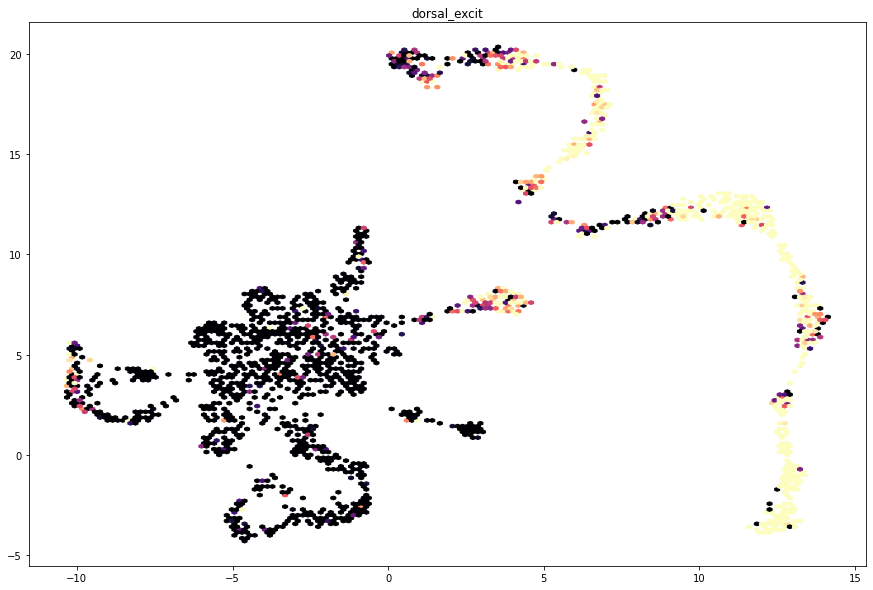

In [157]:
curMmClass = "dorsal_excit";
#curMmClass = "dorsal_inhib";
#curMmClass = "midVent";

curPlot = plt.hexbin(x=dh_mac_neuron_ann.obsm["X_umap"][:,0],y=dh_mac_neuron_ann.obsm["X_umap"][:,1],C=sigScoreFullD[curMmClass],gridsize=150,cmap="magma",vmin=0.25,vmax=20)
plt.title(curMmClass)
curPlotFn = "/home/apfennin/projects/dorsalHorn/out31/macMarkerFig/cellClass.dorsal_excit_hex.3.1.1.1.pdf";
plt.savefig(curPlotFn)
#curPlot

#curPlot.savefig(curPlotFn);


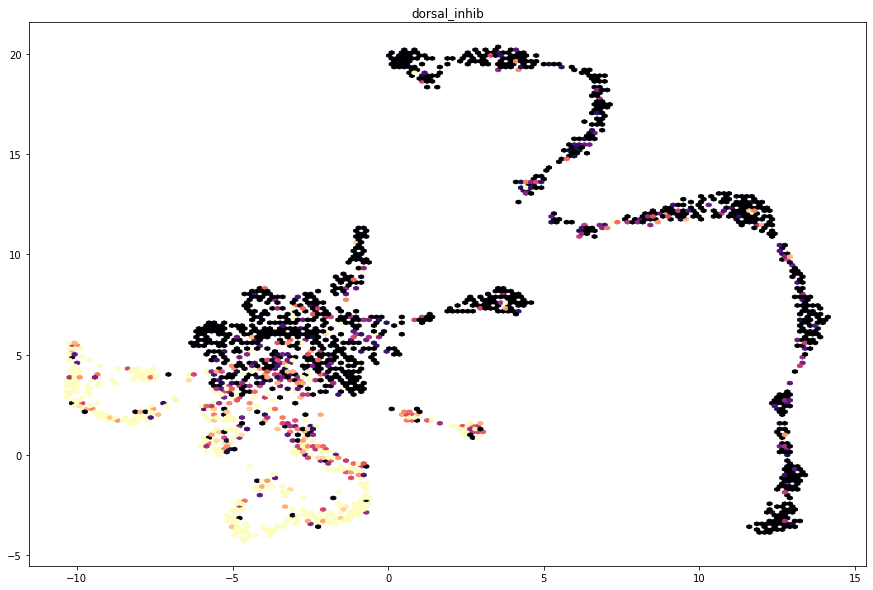

In [158]:
#curMmClass = "dorsal_excit";
curMmClass = "dorsal_inhib";
#curMmClass = "midVent";

curPlot = plt.hexbin(x=dh_mac_neuron_ann.obsm["X_umap"][:,0],y=dh_mac_neuron_ann.obsm["X_umap"][:,1],C=sigScoreFullD[curMmClass],gridsize=150,cmap="magma",vmin=0.25,vmax=20)
plt.title(curMmClass)
curPlotFn = "/home/apfennin/projects/dorsalHorn/out31/macMarkerFig/cellClass.dorsal_inhib_hex.3.1.1.1.pdf";
plt.savefig(curPlotFn)
#curPlot

#curPlot.savefig(curPlotFn);


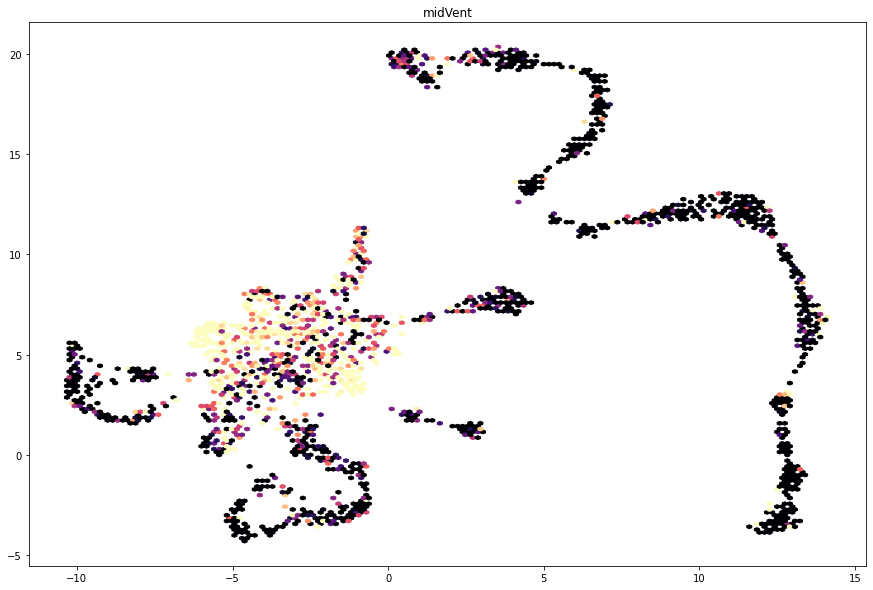

In [159]:
#curMmClass = "dorsal_excit";
#curMmClass = "dorsal_inhib";
curMmClass = "midVent";

curPlot = plt.hexbin(x=dh_mac_neuron_ann.obsm["X_umap"][:,0],y=dh_mac_neuron_ann.obsm["X_umap"][:,1],C=sigScoreFullD[curMmClass],gridsize=150,cmap="magma",vmin=0.25,vmax=20)
plt.title(curMmClass)
curPlotFn = "/home/apfennin/projects/dorsalHorn/out31/macMarkerFig/cellClass.midVent_hex.3.1.1.1.pdf";
plt.savefig(curPlotFn)
#curPlot

#curPlot.savefig(curPlotFn);


In [165]:
#curMm2macSigScoreFull_df

macClV = dh_macCyn2_neuron_ann.obs['cluster_type'].cat.categories.values
#dh_mac_neuron_annot_df.cluster_type.unique().astype(str)


compMmMacClustStatD = {};
compMmMacClustPvalD = {};

for curMacClust in macClV :
    curFg_df = curMm2macSigScoreFull_df[dh_mac_neuron_ann.obs.cluster_type == curMacClust];
    curBg_df = curMm2macSigScoreFull_df[dh_mac_neuron_ann.obs.cluster_type != curMacClust];
    
    curMmCompStatV = [];
    curMmCompPvalV = [];
    for curMmClust in curMmCellClassV :
        #curTtest = stats.ttest_ind(curFg_df[curMmClust],curBg_df[curMmClust])
        curStat,curPval = stats.ttest_ind(curFg_df[curMmClust],curBg_df[curMmClust]);
        #print(curTtest);
        curMmCompStatV.append(curStat);
        curMmCompPvalV.append(curPval);
        
    compMmMacClustStatD[curMacClust] = curMmCompStatV;
    compMmMacClustPvalD[curMacClust] = curMmCompPvalV;
        
compMmMacClustStat_df = pd.DataFrame.from_dict(compMmMacClustStatD);
compMmMacClustStat_df.index = curMmCellClassV;

In [166]:
compMmMacClustStat_df

,GLUT1,GLUT2,GLUT3,GLUT4,GLUT5,GLUT6,GLUT7,GLUT8,GLUT9,GLUT10,GLUT11,GABA1,GABA2_1,GABA2_2,GABA3,GABA4_1,GABA4_2,GABA5,midVen
dorsal_excit,11.604543,17.808777,12.844244,3.862626,5.542918,2.105139,6.169487,10.137414,13.541722,12.955303,-3.343395,-8.042685,-4.335019,-4.136499,-3.599119,-4.987348,-7.889527,-3.881978,-30.868055
dorsal_inhib,-4.372566,-4.311637,-3.897981,-0.045575,-5.743835,-6.032413,-6.250581,-3.228501,-7.018374,-5.301487,-3.110244,10.329000,6.151987,7.014805,6.157024,14.742118,14.330635,21.882830,-12.988876
midVent,-4.871543,-9.996693,-9.510938,-4.332853,-2.393142,-0.895314,-1.075358,-5.814920,-8.407443,-8.091998,5.695127,2.016039,0.642373,-1.398571,-1.937536,-5.794837,-0.686046,-5.708742,34.307616


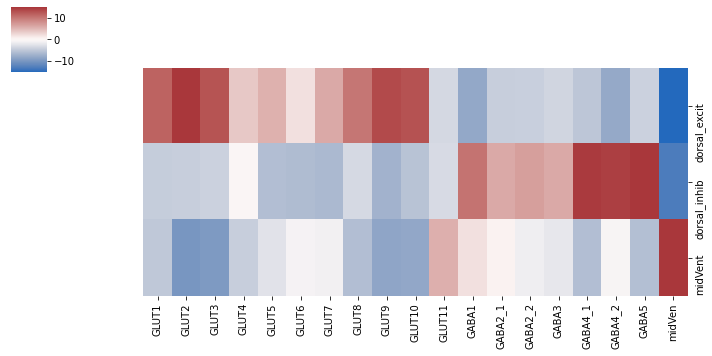

In [172]:
allMacOrdV = macClV
#compMmMacClustStat3_df = compMmMacClustStat_df[allMacOrdV]
compMmMacClustStat3_df = compMmMacClustStat_df;
compSpecHm = sns.clustermap(compMmMacClustStat3_df, cmap="vlag", col_cluster=False,figsize=(10, 5),
                            row_cluster=False, center=0,vmax=15,vmin=-15)
compSpecOutFn = "/home/apfennin/projects/dorsalHorn/out31/macMarkerFig/macaqueClusterClasses.3.1.1.1.pdf"
plt.savefig(compSpecOutFn)

In [ ]:
############ Analyze the neuron subtypes ###############

In [176]:
#Create subsets of the ann data for each cell class
annSubsetMacD = {};
for curClass in mmCellClassV :
    annSubsetMacD[curClass] = dh_mac_neuron_ann[dh_mac_neuron_ann.obs["mouse_class"] == curClass];


/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [188]:
#Loop through the clusters and calculate similaritiy to mouse subclusters
#Use numMarkers = 25, small gene sets
numMarkers = 50;
curMm2macSigScoreFulldfD = {};

for curClass in mmCellClassV :
    curMm_ann = annSubsetMmD[curClass];
    curMac_ann = annSubsetMacD[curClass];
    
    curMm2macSigScoreFullD = {};
    curMac_exp_df = pd.DataFrame.sparse.from_spmatrix(data=curMac_ann.X,index=curMac_ann.obs.index.values,columns=curMac_ann.var_names.values )
    
    

    for curMmSubclass in mmClass2clustD[curClass] :
    
        curGeneLen = len(curMm_ann.uns['rank_genes_groups']["scores"])

        curMmClass_sigDict = {};

        curMmClass_sigDict["names"] = curMm_ann.uns['rank_genes_groups']["names"][curMmSubclass][0:numMarkers].tolist();
        curMmClass_sigDict["scores"] = curMm_ann.uns['rank_genes_groups']["scores"][curMmSubclass][0:numMarkers].tolist();

        curMmClass_sigDict["names"] = curMmClass_sigDict["names"] + curMm_ann.uns['rank_genes_groups']["names"][curMmSubclass][(curGeneLen-numMarkers):curGeneLen].tolist();
        curMmClass_sigDict["scores"] = curMmClass_sigDict["scores"] + curMm_ann.uns['rank_genes_groups']["scores"][curMmSubclass][(curGeneLen-numMarkers):curGeneLen].tolist();
        #curHgClass_sigDict["names_cap"] = [gene.upper() for gene in curMmClust_sigDict["names"]] 
        curMmClass_sigDict["names_use"] = curMmClass_sigDict["names"];
        curMmClass_sigDf = pd.DataFrame(data=curMmClass_sigDict,index=curMmClass_sigDict["names_use"]);
        #print(curMmClust_sigDf);

        curMm2macSigScoreFullD[curMmSubclass] = sig_score(curMac_exp_df,curMmClass_sigDf);
        #stophere();
        
    curMm2macSigScoreFull_df = pd.DataFrame(data=curMm2macSigScoreFullD,index=curMac_ann.obs.index.values)

    curMmCellClassV = curMm2macSigScoreFull_df.columns.tolist()

    #Subcluster with the highest score
    annSubsetMacD[curClass].obs["pred_mm_subclass_label"] = curMm2macSigScoreFull_df.apply(lambda x: curMmCellClassV[x.tolist().index(max(x))],axis=1);
    #The score of that subcluster
    annSubsetMacD[curClass].obs["pred_mm_subclass_score"] = curMm2macSigScoreFull_df.apply(lambda x: max(x),axis=1);
    
    curMm2macSigScoreFulldfD[curClass] = curMm2macSigScoreFull_df;

/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/pr

/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/pr

/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/pr

/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/pr

/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/pr

/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/pr

/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/apfennin/miniconda3/lib/python3.8/site-packages/sklearn/pr

In [189]:
#Set the subclusters mouse_class
curClass = 'dorsal_excit';
curMac_ann = annSubsetMacD[curClass];

In [190]:
#Make subcluster annotations based on cell counts
tmpObs_df = curMac_ann.obs;
tmpObs_pivot_df = tmpObs_df.pivot_table(index='cluster_type', columns='pred_mm_subclass_label', aggfunc='size', fill_value=0)
curMac2mmV = tmpObs_pivot_df.apply(lambda x: tmpObs_pivot_df.columns[x.tolist().index(max(x))],axis=1)
tmpObs_pivot_df


pred_mm_subclass_label,Excit-01,Excit-02,Excit-03,Excit-04,Excit-05,Excit-06,Excit-07,Excit-08,Excit-09,Excit-10,Excit-11,Excit-12,Excit-13,Excit-14,Excit-15,Excit-16,Excit-17,Excit-18,Excit-19
cluster_type,,,,,,,,,,,,,,,,,,,
GLUT1,37,5,3,1,0,0,4,30,27,14,7,3,2,1,0,2,3,2,1
GLUT2,4,2,3,1,2,2,7,106,2,48,21,5,6,0,1,2,5,4,1
GLUT3,0,5,0,18,0,1,8,1,4,3,1,0,5,3,6,5,13,43,36
GLUT4,0,0,1,1,2,2,0,1,0,0,2,1,3,2,8,0,0,4,22
GLUT5,0,1,0,0,1,0,4,0,1,6,0,1,0,2,31,54,1,3,0
GLUT6,1,1,0,2,0,5,4,2,0,0,3,9,3,22,36,27,3,1,4
GLUT7,0,2,3,20,43,42,4,0,0,0,1,4,0,0,2,0,1,1,1
GLUT8,25,23,11,1,2,0,1,1,1,0,1,2,1,2,0,0,2,1,2
GLUT9,1,3,31,52,1,1,1,0,0,0,0,1,2,0,1,1,1,0,2


In [191]:
#Read in neuron distance metrics from ryan
mmClustDist_df = pd.read_csv("/home/apfennin/projects/dorsalHorn/mmData/neurons_distance_2.csv",index_col=0);
#mmClustDist_df

In [192]:
#Make subcluster annotations based on cell score distributions

curMacClV = tmpObs_pivot_df.index.tolist()
curMmCellClassV = mmClass2clustD[curClass];
curSigScore_df = curMm2macSigScoreFulldfD[curClass];

curCompMmMacClustStatD = {};
curCompMmMacClustPvalD = {};

for curMacClust in curMacClV :
    curFg_df = curSigScore_df[dh_mac_neuron_ann.obs.cluster_type == curMacClust];
    curBg_df = curSigScore_df[dh_mac_neuron_ann.obs.cluster_type != curMacClust];
    
    curMmCompStatV = [];
    curMmCompPvalV = [];
    for curMmClust in curMmCellClassV :
        #curTtest = stats.ttest_ind(curFg_df[curMmClust],curBg_df[curMmClust])
        curStat,curPval = stats.ttest_ind(curFg_df[curMmClust],curBg_df[curMmClust]);
        #print(curTtest);
        curMmCompStatV.append(curStat);
        curMmCompPvalV.append(curPval);
        
    curCompMmMacClustStatD[curMacClust] = curMmCompStatV;
    curCompMmMacClustPvalD[curMacClust] = curMmCompPvalV;
        
curCompMmMacClustStat_df = pd.DataFrame.from_dict(curCompMmMacClustStatD);
curCompMmMacClustStat_df.index = curMmCellClassV;

<ipython-input-192-0d60351a089f>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curFg_df = curSigScore_df[dh_mac_neuron_ann.obs.cluster_type == curMacClust];
<ipython-input-192-0d60351a089f>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curBg_df = curSigScore_df[dh_mac_neuron_ann.obs.cluster_type != curMacClust];


In [193]:
#Create linkage for current clusters
curMmClustDist_df = mmClustDist_df[mmClustDist_df.index.isin(curMmCellClassV)]
curMmClustDist_df = curMmClustDist_df.reindex(curMmCellClassV);
curMmClustDist_df = curMmClustDist_df[curMmClustDist_df.index]
curMmClustDist_mx = squareform(curMmClustDist_df);
#curMmClustDist_mx
curMmClustDist_linkage = linkage(curMmClustDist_mx,method='ward');
#curMmClustDist_df
#curMmClustDist_linkage

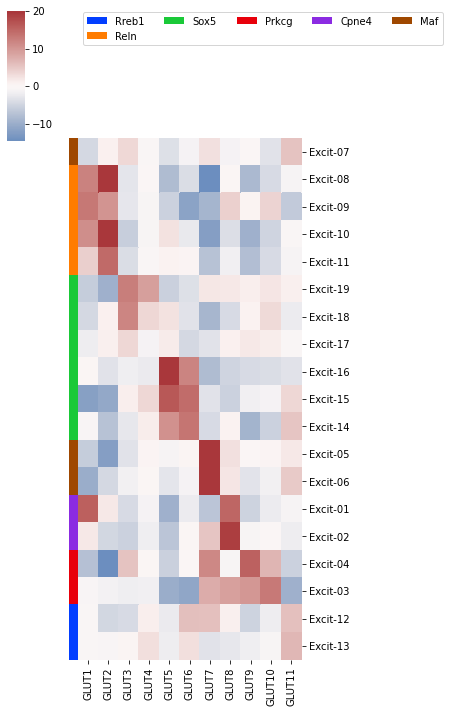

In [194]:
#Plot the cell type similarity of excitatory neurons
curMmCellOrdV = [];
for curMmCell in mmFullClustOrdV :
    if curMmCell in curMmClustDist_df.index.tolist() :
        curMmCellOrdV.append(curMmCell);
    
newMmCellOrdV = ['Excit-09','Excit-08','Excit-10','Excit-11','Excit-19','Excit-18','Excit-16','Excit-17',
                 'Excit-15','Excit-14','Excit-12','Excit-13','Excit-01','Excit-02','Excit-06','Excit-05',
                 'Excit-03','Excit-04','Excit-07']; #Old order

newMmCellOrdV = ['Excit-07','Excit-08','Excit-09','Excit-10','Excit-11','Excit-19','Excit-18','Excit-17','Excit-16',
                 'Excit-15','Excit-14','Excit-05','Excit-06','Excit-01','Excit-02','Excit-04',
                 'Excit-03','Excit-12','Excit-13']; #2.2 order


curCompMmMacClustStat_2_df = curCompMmMacClustStat_df.reindex(newMmCellOrdV);
newMacCellOrdV = curMacClV;
#curCompMmMacClustStat_2_df = curCompMmMacClustStat_2_df[['13','18','9','15','10','12','6','19','1','7']]
curCompMmMacClustStat_2_df = curCompMmMacClustStat_2_df[newMacCellOrdV]


#Create macaque-mouse comparison heatmap
curMmCellClassFamV = [ mmClust2famD[curClust] for curClust in curCompMmMacClustStat_2_df.index.tolist()];
curMmCellClassFamUV = list(set(curMmCellClassFamV));
curMmFamColD = dict(zip(map(str, curMmCellClassFamUV), sns.color_palette("bright")))
curMmCellClassCoV = [ curMmFamColD[curFam] for curFam in curMmCellClassFamV];
curMmCellClassCoV

compSpecHm = sns.clustermap(curCompMmMacClustStat_2_df, cmap="vlag",figsize=(5, 10),row_colors=curMmCellClassCoV,
                           center=0, vmax=20, row_cluster=False,col_cluster=False)

#Add the legend
for label in curMmCellClassFamUV:
    compSpecHm.ax_col_dendrogram.bar(0, 0, color=curMmFamColD[label],
                            label=label, linewidth=0)
compSpecHm.ax_col_dendrogram.legend(loc="upper left", ncol=5)

compSpecOutFn = "/home/apfennin/projects/dorsalHorn/out31/macMarkerFig/macHmMap.Excit.3.1.1.1.pdf"
plt.savefig(compSpecOutFn)
#compSpecHm.cax.set_position([.97, .2, .03, .45])

In [ ]:
############ Analyze the inhibatory dataset ###############

In [195]:
#Set the subclusters
curClass = 'dorsal_inhib';
curMac_ann = annSubsetMacD[curClass];

In [196]:
#Make subcluster annotations based on cell counts
tmpObs_df = curMac_ann.obs;
tmpObs_pivot_df = tmpObs_df.pivot_table(index='cluster_type', columns='pred_mm_subclass_label', aggfunc='size', fill_value=0)
curMac2mmV = tmpObs_pivot_df.apply(lambda x: tmpObs_pivot_df.columns[x.tolist().index(max(x))],axis=1)
tmpObs_pivot_df


pred_mm_subclass_label,Inhib-01,Inhib-02,Inhib-03,Inhib-04,Inhib-05,Inhib-06,Inhib-07,Inhib-08,Inhib-09,Inhib-10,Inhib-11,Inhib-12,Inhib-13
cluster_type,,,,,,,,,,,,,
GABA1,3,1,1,5,0,33,22,35,1,1,0,3,4
GABA2_1,38,10,1,2,0,4,2,4,1,0,0,1,2
GABA2_2,23,30,3,0,0,5,2,0,3,0,3,1,1
GABA3,2,4,1,1,3,0,0,2,0,4,0,31,26
GABA4_1,10,1,6,27,37,1,0,1,0,2,1,2,3
GABA4_2,3,38,8,3,7,2,3,12,5,5,3,9,2
GABA5,1,2,9,12,11,5,7,9,14,23,84,8,17


In [197]:
#Make subcluster annotations based on cell score distributions

#curMacClV = curMac_ann.obs["refined_clusters"].unique().tolist();
curMacClV = tmpObs_pivot_df.index.tolist()
curMmCellClassV = mmClass2clustD[curClass];
curSigScore_df = curMm2macSigScoreFulldfD[curClass];

curCompMmMacClustStatD = {};
curCompMmMacClustPvalD = {};

for curMacClust in curMacClV :
    curFg_df = curSigScore_df[dh_mac_neuron_ann.obs.cluster_type == curMacClust];
    curBg_df = curSigScore_df[dh_mac_neuron_ann.obs.cluster_type != curMacClust];
    
    curMmCompStatV = [];
    curMmCompPvalV = [];
    for curMmClust in curMmCellClassV :
        #curTtest = stats.ttest_ind(curFg_df[curMmClust],curBg_df[curMmClust])
        curStat,curPval = stats.ttest_ind(curFg_df[curMmClust],curBg_df[curMmClust]);
        #print(curTtest);
        curMmCompStatV.append(curStat);
        curMmCompPvalV.append(curPval);
        
    curCompMmMacClustStatD[curMacClust] = curMmCompStatV;
    curCompMmMacClustPvalD[curMacClust] = curMmCompPvalV;
        
curCompMmMacClustStat_df = pd.DataFrame.from_dict(curCompMmMacClustStatD);
curCompMmMacClustStat_df.index = curMmCellClassV;

<ipython-input-197-e3f552e91d5a>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curFg_df = curSigScore_df[dh_mac_neuron_ann.obs.cluster_type == curMacClust];
<ipython-input-197-e3f552e91d5a>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curBg_df = curSigScore_df[dh_mac_neuron_ann.obs.cluster_type != curMacClust];


In [198]:
#Create linkage for current clusters
curMmClustDist_df = mmClustDist_df[mmClustDist_df.index.isin(curMmCellClassV)]
curMmClustDist_df = curMmClustDist_df.reindex(curMmCellClassV);
curMmClustDist_df = curMmClustDist_df[curMmClustDist_df.index]
curMmClustDist_mx = squareform(curMmClustDist_df);
#curMmClustDist_mx
curMmClustDist_linkage = linkage(curMmClustDist_mx,method='ward');
#curMmClustDist_df
#curMmClustDist_linkage

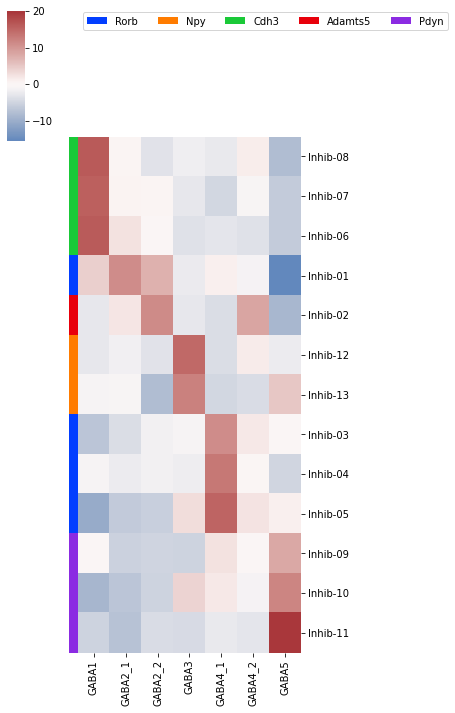

In [227]:
#Create pallete for 
newMmCellOrdV = ['Inhib-08','Inhib-07','Inhib-06','Inhib-01','Inhib-02',
                 'Inhib-12','Inhib-13','Inhib-03','Inhib-04','Inhib-05','Inhib-09','Inhib-10','Inhib-11'];
curCompMmMacClustStat_2_df = curCompMmMacClustStat_df.reindex(newMmCellOrdV);
newMacCellOrdV = curMacClV;
curCompMmMacClustStat_2_df = curCompMmMacClustStat_2_df[newMacCellOrdV]

#Create macaque-mouse comparison heatmap
curMmCellClassFamV = [ mmClust2famD[curClust] for curClust in curCompMmMacClustStat_2_df.index.tolist()];
curMmCellClassFamUV = list(set(curMmCellClassFamV));
curMmFamColD = dict(zip(map(str, curMmCellClassFamUV), sns.color_palette("bright")))
curMmCellClassCoV = [ curMmFamColD[curFam] for curFam in curMmCellClassFamV];
curMmCellClassCoV

compSpecHm = sns.clustermap(curCompMmMacClustStat_2_df, cmap="vlag",figsize=(5, 10),row_colors=curMmCellClassCoV,
                           center=0, vmax=20, row_cluster=False,col_cluster=False)


#Add the legend
for label in curMmCellClassFamUV:
    compSpecHm.ax_col_dendrogram.bar(0, 0, color=curMmFamColD[label],
                            label=label, linewidth=0)
compSpecHm.ax_col_dendrogram.legend(loc="upper left", ncol=5)
#compSpecHm.cax.set_position([.97, .2, .03, .45])
compSpecOutFn = "/home/apfennin/projects/dorsalHorn/out31/macMarkerFig/macHmMap.Inhib.3.1.1.1.pdf"
plt.savefig(compSpecOutFn)

In [ ]:
############### Plot the final cluster assignments #######################

In [202]:
mac2mmfamD = {};


mac2mmfamD['GLUT1'] = 'Ex-Reln';
mac2mmfamD['GLUT2'] = 'Ex-Reln';
mac2mmfamD['GLUT3'] = 'Ex-Sox5';
mac2mmfamD['GLUT4'] = 'Ex-Sox5';
mac2mmfamD['GLUT5'] = 'Ex-Sox5';
mac2mmfamD['GLUT6'] = 'Ex-Sox5';
mac2mmfamD['GLUT7'] = 'Ex-Maf';
mac2mmfamD['GLUT8'] = 'Ex-Cpne3';
mac2mmfamD['GLUT9'] = 'Ex-Prkcg';
mac2mmfamD['GLUT10'] = 'Ex-Prkcg';
mac2mmfamD['GLUT11'] = 'Ex-Rreb1';


mac2mmfamD['GABA1'] = 'Inh-Cdh3';
mac2mmfamD['GABA2_1'] = 'Inh-Rorb';
mac2mmfamD['GABA2_2'] = 'Inh-Adamts5';
mac2mmfamD['GABA3'] = 'Inh-Npy';
mac2mmfamD['GABA4_1'] = 'Inh-Rorb';
mac2mmfamD['GABA4_2'] = 'Inh-Adamts5';
mac2mmfamD['GABA5'] = 'Inh-Pdyn';

mac2mmfamD['midVen'] = 'midVent';


In [205]:
dh_mac_neuron_ann.obs["mouse_family"] = [mac2mmfamD[curClust] for curClust in dh_mac_neuron_ann.obs["cluster_type"]]
dh_mac_neuron_mmComp_ann.obs["mouse_family"] = [mac2mmfamD[curClust] for curClust in dh_mac_neuron_mmComp_ann.obs["cluster_type"]]

/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'pred_mm_class_label' as categorical
... storing 'mouse_class' as categorical
... storing 'mouse_family' as categorical


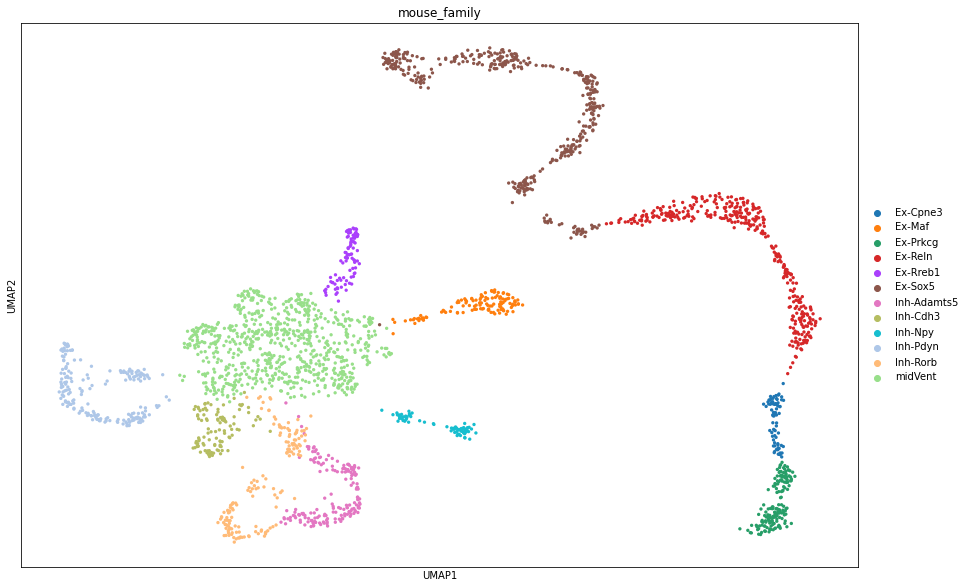

In [204]:
#compSpecOutFn = "/home/apfennin/projects/dorsalHorn/out21/macMarkerFig/mmMac.familyAssign.umap.2.2.2.pdf"
#sc.pl.umap(dh_mac_neuron_ann, color='mouse_family',save=compSpecOutFn)
sc.pl.umap(dh_mac_neuron_ann, color='mouse_family',save='mmMac.familyAssign.umap.3.1.1.1.pdf')
#plt.savefig(compSpecOutFn)

In [211]:
#Store the version of the object for quantative comparison to mouse markers
macSplit_neuron_comp_h5ad_fn = "/home/apfennin/projects/dorsalHorn/rheMacData/macaque_integrated_famSplit.comp.3.1.1.h5ad";
dh_mac_neuron_mmComp_ann.write_h5ad(macSplit_neuron_comp_h5ad_fn); #Only do once


... storing 'mouse_class' as categorical
... storing 'mouse_family' as categorical


In [212]:
#Store the version of the object for quantative comparison to mouse markers
macSplit_neuron_h5ad_fn = "/home/apfennin/projects/dorsalHorn/rheMacData/macaque_integrated_famSplit.3.1.1.h5ad";
dh_mac_neuron_ann.write_h5ad(macSplit_neuron_h5ad_fn); #Only do once


... storing 'mouse_family' as categorical


In [79]:
################################################
# Rank genes and compare across conditions
################################################

In [ ]:
######## Compute macaque specializations ##############

In [209]:
#Create subsets of the ann data for each cell class - integrated
annSubsetMacFiltD = {};
for curClass in ['dorsal_excit','dorsal_inhib','midVent'] :
    annSubsetMacFiltD[curClass] = dh_mac_neuron_mmComp_ann[dh_mac_neuron_mmComp_ann.obs["mouse_class"] == curClass];


/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [210]:
#Get differential genes within excitatory and inhibitory based on mouse family
sc.tl.rank_genes_groups(annSubsetMacFiltD['dorsal_excit'], 'mouse_family', method='wilcoxon',rankby_abs=False)
sc.tl.rank_genes_groups(annSubsetMacFiltD['dorsal_inhib'], 'mouse_family', method='wilcoxon',rankby_abs=False)

/home/apfennin/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'mouse_class' as categorical
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'mouse_family' as categorical
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'mouse_class' as categorical
Trying to set attribute `.obs` of view, copying.
Variable names are not

In [213]:
###### Compare markers based on cell class ######

In [214]:
#Calculate family mouse markers
sc.tl.rank_genes_groups(mmDh_raw_neuron_3adultFilt_ann, 'cell_class', method='wilcoxon',rankby_abs=False, n_genes=15157)


In [215]:
#Calculate family macaque markers
sc.tl.rank_genes_groups(dh_mac_neuron_mmComp_ann, 'mouse_class', method='wilcoxon',rankby_abs=False, n_genes=15157)

In [216]:
#Explore relationship
mmClassResultRA = mmDh_raw_neuron_3adultFilt_ann.uns['rank_genes_groups']
#mmClassResultRA

In [217]:
mmClassResultRA['logfoldchanges']

rec.array([(  5.608469 ,   3.472132, 16.37186  ),
           (  4.4342833,   2.624607, 10.729226 ),
           (  2.6052947,   5.682296, 11.020888 ), ...,
           ( -6.9597745, -12.955423, -2.4550176),
           (-12.941902 ,  -5.61895 , -3.2222722),
           (-26.241888 ,  -5.761836, -4.363223 )],
          dtype=[('dorsal_excit', '<f4'), ('dorsal_inhib', '<f4'), ('midVent', '<f4')])

In [218]:
useGroupsV = mmClassResultRA['names'].dtype.names
curFnHead = "/home/apfennin/projects/dorsalHorn/out31/xspecMarkerList/";

In [219]:
for curGroup in useGroupsV :
    curPd = pd.DataFrame(
    {key : mmClassResultRA[key][curGroup]
    for key in ['names', 'scores','pvals','pvals_adj','logfoldchanges']})
    curFn = curFnHead + "xspecMarkerList." + "mm" + "." + curGroup + ".2.2.2.csv";
    curPd.to_csv(curFn);
        

In [220]:
macClassResultRA = dh_mac_neuron_mmComp_ann.uns['rank_genes_groups']

In [221]:
#Print results out in dataframe
for curGroup in useGroupsV :
    curPd = pd.DataFrame(
    {key : macClassResultRA[key][curGroup]
    for key in ['names', 'scores','pvals','pvals_adj','logfoldchanges']})
    curFn = curFnHead + "xspecMarkerList." + "mac" + "." + curGroup + ".2.2.2.csv";
    curPd.to_csv(curFn);

In [89]:
###### Compare markers based on neuron subtypes ######
#annSubsetRawMmD[curClass] #family
#annSubsetMacFiltD[curClass] #mouse_family

In [222]:
#Calculate the marker genes for each family
sc.tl.rank_genes_groups(annSubsetRawMmD['dorsal_excit'], 'family', method='wilcoxon',rankby_abs=False, n_genes=15157)
sc.tl.rank_genes_groups(annSubsetRawMmD['dorsal_inhib'], 'family', method='wilcoxon',rankby_abs=False, n_genes=15157)
sc.tl.rank_genes_groups(annSubsetMacFiltD['dorsal_excit'], 'mouse_family', method='wilcoxon',rankby_abs=False, n_genes=15157)
sc.tl.rank_genes_groups(annSubsetMacFiltD['dorsal_inhib'], 'mouse_family', method='wilcoxon',rankby_abs=False, n_genes=15157)


In [223]:
#Print markers of current mouse exciatory subtypes
curResultRA = annSubsetRawMmD['dorsal_excit'].uns['rank_genes_groups']
curUseGroupsV = curResultRA['names'].dtype.names
curSpec = "mm";
curClass = "excit"

for curGroup in curUseGroupsV :
    curPd = pd.DataFrame(
    {key : curResultRA[key][curGroup]
    for key in ['names', 'scores','pvals','pvals_adj','logfoldchanges']})
    curFn = curFnHead + "xspecMarkerList." + curSpec + "." + curClass + "_" + curGroup + ".2.2.2.csv";
    curPd.to_csv(curFn);

In [224]:
#Print markers of current mouse inhibitory subtypes
curResultRA = annSubsetRawMmD['dorsal_inhib'].uns['rank_genes_groups']
curUseGroupsV = curResultRA['names'].dtype.names
curSpec = "mm";
curClass = "inhib"

for curGroup in curUseGroupsV :
    curPd = pd.DataFrame(
    {key : curResultRA[key][curGroup]
    for key in ['names', 'scores','pvals','pvals_adj','logfoldchanges']})
    curFn = curFnHead + "xspecMarkerList." + curSpec + "." + curClass + "_" + curGroup + ".2.2.2.csv";
    curPd.to_csv(curFn);

In [225]:
curResultRA = annSubsetMacFiltD['dorsal_excit'].uns['rank_genes_groups']
curUseGroupsV = curResultRA['names'].dtype.names
curSpec = "mac";
curClass = "excit"

for curGroup in curUseGroupsV :
    curPd = pd.DataFrame(
    {key : curResultRA[key][curGroup]
    for key in ['names', 'scores','pvals','pvals_adj','logfoldchanges']})
    curFn = curFnHead + "xspecMarkerList." + curSpec + "." + curClass + "_" + curGroup + ".2.2.2.csv";
    curPd.to_csv(curFn);

In [226]:
curResultRA = annSubsetMacFiltD['dorsal_inhib'].uns['rank_genes_groups']
curUseGroupsV = curResultRA['names'].dtype.names
curSpec = "mac";
curClass = "inhib"

for curGroup in curUseGroupsV :
    curPd = pd.DataFrame(
    {key : curResultRA[key][curGroup]
    for key in ['names', 'scores','pvals','pvals_adj','logfoldchanges']})
    curFn = curFnHead + "xspecMarkerList." + curSpec + "." + curClass + "_" + curGroup + ".2.2.2.csv";
    curPd.to_csv(curFn);